In [2]:
library(plyr)
library(ggplot2)
library(rpart)

In [3]:
path = '~/Airbnb/'
df <- read.csv(paste0(path, 'listings.csv'))

In [4]:
dim(df)

[1] 50599   106

In [5]:
new_features <- read.csv(paste0(path, 'listings_ft.csv'))
dim(new_features)

[1] 50599    10

In [6]:
amenities <- read.csv(paste0(path, 'amenities_df.csv'))
dim(amenities)

[1] 50599   136

In [7]:
df <- cbind(df, amenities[,-c(1:5)], new_features)
dim(df)

[1] 50599   247

In [8]:
imp_amenities <- c('Wifi','Heating','Essentials','Kitchen','Smokedetector','Airconditioning',
                   'Carbonmonoxidedetector','TV','Shampoo','Hairdryer','Laptopfriendlyworkspace',
                   'Iron','Washer','Dryer','Dishesandsilverware','Lockonbedroomdoor','Stove',
                   'Firstaidkit','Oven','Freestreetparking','Cookingbasics','Coffeemaker',
                   'Internet','Elevator','Family.kidfriendly','CableTV','Selfcheck.in',
                   'Extrapillowsandblankets','Privateentrance','Longtermstaysallowed',
                   'Buzzer.wirelessintercom','translationmissing.en.hosting_amenity_50',
                   'Dishwasher','Hostgreetsyou','translationmissing.en.hosting_amenity_49',
                   'Petsallowed','Lockbox','Gym','Paidparkingoffpremises','X24.hourcheck.in',
                   'Bathtub','Patioorbalcony','Gardenorbackyard','Petsliveonthisproperty')

### Data Cleaning

In [9]:
# Remove '$' from price
df$price = suppressWarnings(sapply(df$price, FUN = function(x) as.integer(sub(",", "", sub(".", "", x)))))

In [10]:
# Eliminate outliers
df <- df[df$number_of_reviews > 0,] # Number of Reviews > 0; 40379 samples
df <- df[df$price <= 500, ]
df <- df[df$price > 0, ]

In [11]:
dim(df) # 39730 rows

[1] 39730   247

In [12]:
# Remove '%' from host_response_rate
df$host_response_rate <- sapply(df$host_response_rate, FUN = function(x) as.integer(sub('%', '', '85%')))

In [13]:
df$host_since_day = as.numeric(as.Date('2019-12-04', format="%Y-%m-%d")-as.Date(df$host_since, format="%Y-%m-%d"))
df$first_review_day = as.numeric(as.Date('2019-12-04', format="%Y-%m-%d")-as.Date(df$first_review, format="%Y-%m-%d"))
df$last_review_day = as.numeric(as.Date('2019-12-04', format="%Y-%m-%d")-as.Date(df$last_review, format="%Y-%m-%d"))

In [14]:
# Remove '$' from extra people
df$extra_people = suppressWarnings(sapply(df$extra_people, FUN = function(x) as.integer(sub(",", "", sub(".", "", x)))))

### Train-Test Split

In [15]:
# Load train test ids
train.id <- read.csv(paste0(path, 'train.csv'))
train.id <- train.id$id
test.id <- read.csv(paste0(path, 'test.csv'))
test.id <- test.id$id

# create train set and test set
train.set <- df[df$id %in% train.id,]
test.set <- df[df$id %in% test.id,]

#print dimension
print(dim(train.set))
print(dim(test.set))

[1] 19787   250
[1] 8481  250


### Functions

In [16]:
r2 <- function(pred.y, true.y){
    sst = sum((true.y - mean(true.y))^2)
    sse = sum((pred.y - true.y)^2)
    #print(sst)
    #print(sse)
    return(1-sse/sst)
    }

### Model Building

In [232]:
features = c('price', 'neighbourhood', 'host_since_day', 'host_location',
            'host_response_time', 'host_is_superhost','host_neighbourhood',
            'host_listings_count', "host_total_listings_count",
            'host_has_profile_pic','host_identity_verified', 'street',
            'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
            'city', 'zipcode', 'property_type', 'room_type', 'accommodates',
            'bathrooms', 'bedrooms','beds', 'bed_type', 'square_feet',
            'guests_included', 'extra_people', 'number_of_reviews',
            'number_of_reviews_ltm', 'review_scores_rating', 'instant_bookable',
            'cancellation_policy', 'require_guest_profile_picture',
            'require_guest_phone_verification', 'calculated_host_listings_count',
            'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
            'first_review_day', 'last_review_day'
            )
features <- c(features, imp_amenities)
train.subset <- train.set[,match(features, colnames(train.set))]
test.subset <- test.set[,match(features, colnames(test.set))]

In [18]:
length(features)

[1] 94

#### Spliting method being Gini index

In [233]:
tree.model <- rpart(price~., data = train.subset, method = 'anova',
                   minsplit = 30, cp = 0, xval = 15, parms=list(split="gini"))
cptable <- tree.model$cptable
max.error.allowed <- sum(cptable[which.min(cptable[,4]),c(4, 5)])
acceptable.cp <- cptable[cptable[,4] < max.error.allowed,]
best.cp <- acceptable.cp[1,1]
cv.r2 <- 1-acceptable.cp[1,c(3,4)]
print(paste0(c('Train.R2: ', 'CV.R2: '), cv.r2))

[1] "Train.R2: 0.661967711559177" "CV.R2: 0.603637446518769"   


#### Spliting method being information

In [219]:
tree.model <- rpart(price~., data = train.subset, method = 'anova',
                   minsplit = 30, cp = 0, xval = 10, parms=list(split="information"))
cptable <- tree.model$cptable
max.error.allowed <- sum(cptable[which.min(cptable[,4]),c(4, 5)])
acceptable.cp <- cptable[cptable[,4] < max.error.allowed,]
best.cp <- acceptable.cp[1,1]
cv.r2 <- 1-acceptable.cp[1,c(3,4)]
print(paste0(c('Train.R2: ', 'CV.R2: '), cv.r2))

[1] "Train.R2: 0.653623430894214" "CV.R2: 0.599148464636983"   


#### Test Evaluation

In [235]:
# Test
tree.model <- rpart(price~., data = train.subset, method = 'anova',
                   minsplit = 30, cp = best.cp , xval = 10,
                   parms=list(split="gini"))
y.pred <- predict(tree.model)
r2(y.pred, as.numeric(train.set$price))
y.pred <- predict(tree.model, newdata = test.subset)
r2(y.pred, as.numeric(test.set$price))

[1] 0.6619677

[1] 0.5923208

In [236]:
tree.model$variable.importance

room_type 
                                 49764012.34 
calculated_host_listings_count_private_rooms 
                                 44158378.66 
 calculated_host_listings_count_entire_homes 
                                 42673401.17 
                                accommodates 
                                 33196617.18 
                                        beds 
                                 22946546.24 
                                     zipcode 
                                 22199163.89 
                      neighbourhood_cleansed 
                                 19418524.40 
                             guests_included 
                                 18637419.72 
                          host_neighbourhood 
                                 17986960.32 
                                    bedrooms 
                                 16572594.70 
                               neighbourhood 
                                 14659727.49 
                                      street 
                                 10015588.55 
                                        city 
                                  7477470.62 
                                   bathrooms 
                                  5595490.15 
                               host_location 
                                  3527260.08 
                neighbourhood_group_cleansed 
                                  2490957.73 
                               property_type 
                                  1293580.80 
                         host_listings_count 
                                   300849.44 
                                 Coffeemaker 
                                   207804.78 
                          Family.kidfriendly 
                                   204149.86 
                                         Gym 
                                   157235.75 
                              host_since_day 
                                    85398.96 
              calculated_host_listings_count 
                                    71352.97 
                                      Washer 
                                    69201.07 
                                extra_people 
                                    58799.89 
                   host_total_listings_count 
                                    38527.79 
                            first_review_day 
                                    28153.70 
                           reviews_per_month 
                                    18793.69 
 calculated_host_listings_count_shared_rooms 
                                    16502.87

In [237]:
printcp(tree.model)


Regression tree:
rpart(formula = price ~ ., data = train.subset, method = "anova", 
    parms = list(split = "gini"), minsplit = 30, cp = best.cp, 
    xval = 10)

Variables actually used in tree construction:
 [1] accommodates           bathrooms              bedrooms              
 [4] guests_included        host_location          host_neighbourhood    
 [7] neighbourhood_cleansed property_type          room_type             
[10] zipcode               

Root node error: 145655863/19787 = 7361.2

n= 19787 

          CP nsplit rel error  xerror      xstd
1  0.3414478      0   1.00000 1.00007 0.0157140
2  0.0782710      1   0.65855 0.65870 0.0119896
3  0.0566488      2   0.58028 0.58974 0.0110982
4  0.0395709      3   0.52363 0.53354 0.0102542
5  0.0223728      4   0.48406 0.49191 0.0092158
6  0.0121058      5   0.46169 0.47059 0.0089052
7  0.0115734      6   0.44958 0.45965 0.0087528
8  0.0081921      7   0.43801 0.44648 0.0085801
9  0.0071176      8   0.42982 0.43872 0.0084757
10 0

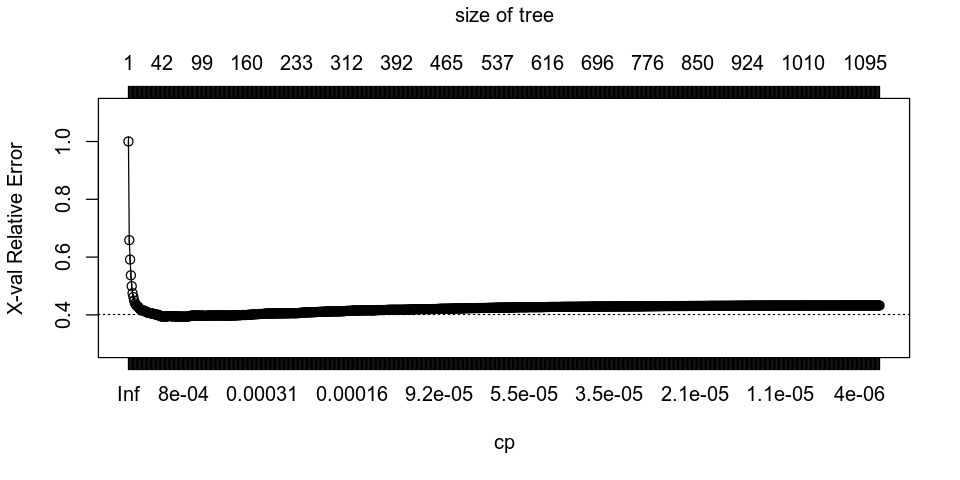

In [227]:
options(repr.plot.width = 8, repr.plot.height = 4)
plotcp(tree.model)

In [242]:
# save tree model result
write.csv(cbind(id = test.set$id, pred.price = y.pred), paste0(path, 'decisiontree_prediction.csv'), row.names = FALSE)

In [248]:
mean(abs(y.pred-test.subset$price))

[1] 36.07672

In [243]:
head(cbind(id = test.set$id, pred.price = y.pred))

,id,pred.price
13,7322,114.29695
27,9782,88.05846
28,9783,77.24730
31,11174,116.46373
32,11708,116.46373
35,12192,88.05846


In [213]:
# Attributes actually used
feature.used <- attr(tree.model$terms,"term.labels")
feature.used

[1] "neighbourhood"                "host_since_day"              
 [3] "host_location"                "host_response_time"          
 [5] "host_is_superhost"            "host_neighbourhood"          
 [7] "host_listings_count"          "host_total_listings_count"   
 [9] "host_has_profile_pic"         "host_identity_verified"      
[11] "street"                       "neighbourhood_cleansed"      
[13] "neighbourhood_group_cleansed" "city"                        
[15] "zipcode"                      "property_type"               
[17] "room_type"                    "accommodates"                
[19] "bathrooms"                    "bedrooms"                    
[21] "beds"                         "bed_type"                    
[23] "square_feet"                  "guests_included"             
[25] "extra_people"                 "number_of_reviews"           
[27] "number_of_reviews_ltm"        "review_scores_rating"        
[29] "instant_bookable"             "cancellation_policy"

## Try Cluster-wise tree model

In [105]:
# Cluster-wise tree model

clustreg=function(dat,k,tries,sed,niter, cp.conservative){
    set.seed(sed)
    dat=as.data.frame(dat) # convert to datframe
    rsq=rep(NA,niter)
    res=list()
    rsq.best=0
    for(l in 1:tries){
        c = sample(1:k,nrow(dat),replace=TRUE)
        yhat=rep(NA,nrow(dat))
        for(i in 1:niter){
            resid=pred=matrix(0,nrow(dat),k)
            for(j in 1:k){
                print(paste0(l, ' try, ', i, ' iteration, cluster ', j, ', tree training'))
                flush.console()
                
                # initial attempt for the tree.model
                tree.model <- rpart(price~., data = dat[c==j,], method = 'anova',
                   minsplit = 30, cp = 0, xval = 10)
                
                # Find the best complexity parameter
                cptable <- tree.model$cptable
                if (cp.conservative == TRUE){
                    max.error.allowed <- sum(cptable[which.min(cptable[,4]),c(4, 5)])
                    acceptable.cp <- cptable[cptable[,4] < max.error.allowed,]
                    best.cp <- acceptable.cp[1,1]
                }
                if (cp.conservative == FALSE){
                    best.cp <- cptable[which.min(cptable[,4]), 1]
                }
                # Build a new tree model
                tree.model <- rpart(price~., data = dat[c==j,], method = 'anova',
                   minsplit = 30, cp = best.cp, xval = 10)
                
                pred[,j]=predict(tree.model,newdata=dat)
                resid[,j] = (pred[,j]-dat[,1])^2
            }
            c = apply(resid,1,which.min)
            for(m in 1:nrow(dat)){
                yhat[m]=pred[m,c[m]]
            }
            rsq[i] = cor(dat[,1],yhat)^2
        }
        if(rsq[niter] > rsq.best){
            rsq.best=rsq[niter] # The assignment of cluster is based on r.squared
            l.best=l
            c.best=c
            yhat.best=yhat
        }
    }
    print("Finalizing Models...")
    flush.console()
    res=list("Complete")
    for(i in 1:k) {
        
        tree.model <- rpart(price~., dat[c.best==i,], method = 'anova',
                      minsplit = 30, cp = 0, xval = 10)
        
        cptable <- tree.model$cptable
        if (cp.conservative == TRUE){
            max.error.allowed <- sum(cptable[which.min(cptable[,4]),c(4, 5)])
            acceptable.cp <- cptable[cptable[,4] < max.error.allowed,]
            best.cp <- acceptable.cp[1,1]
        }
        if (cp.conservative == FALSE){
            best.cp <- cptable[which.min(cptable[,4]), 1]
        }
        tree.model <- rpart(price~., dat[c.best==i,], method = 'anova',
                   minsplit = 30, cp = best.cp, xval = 10)
        
        res[[i]] = tree.model
    }
    return(list(data=dat,nclust=k,tries=tries,seed=sed,
                rsq.best=rsq.best,number.loops=niter, 
                Best.try=l.best,cluster=c.best,results=res))
}

In [43]:
# Prediction for the test-set label

clustreg.predict=function(results,newdat,pred.class){
    yhat=rep(NA,nrow(newdat))
    resid=pred=matrix(0,nrow(newdat),length(table(results$cluster)))
    for (j in 1:length(table(results$cluster))){
        pred[,j] = predict(results$results[[as.integer(j)]], newdata=newdat)
        resid[,j] = (pred[,j]-newdat[,1])^2
    }
    c = apply(resid,1,which.min)
    for(m in 1:nrow(newdat)) {
        yhat[m]=pred[m,c[m]]
    }
    rsq = cor(newdat[,1],yhat)^2
    return(list(results=results,newdata=newdat,cluster=c,yhat=yhat,rsq=rsq))
}

In [44]:
# Prediction for the test-set price

clustreg.pred=function(results,newdat,pred.class){
    yhat=rep(NA,nrow(newdat))
    k = length(table(pred.class))
    for (j in 1:k){
        class.ind <- c(1:length(pred.class))[pred.class == j]
        yhat[class.ind] <- predict(results$results[[j]], newdata = newdat[class.ind,])
    }
    rsq = cor(newdat[,1],yhat)^2
    return(list(results=results,newdata=newdat,yhat=yhat,rsq=rsq))
}

In [77]:
cr.2$results[[2]]$variable.importance

zipcode 
                                 21519696.79 
                                    bedrooms 
                                 20698235.51 
                      neighbourhood_cleansed 
                                 16760279.07 
                          host_neighbourhood 
                                 14107486.60 
                                accommodates 
                                 12008975.40 
                               neighbourhood 
                                 10097234.49 
                                        beds 
                                  8531586.98 
                             guests_included 
                                  7273722.86 
                                   bathrooms 
                                  3494169.00 
                                      street 
                                  3379157.79 
                neighbourhood_group_cleansed 
                                  2874713.77 
                               host_location 
                                  2473473.36 
                                        city 
                                   888426.12 
                                   room_type 
                                   422558.24 
calculated_host_listings_count_private_rooms 
                                   362043.73 
 calculated_host_listings_count_entire_homes 
                                   313006.10 
                         host_listings_count 
                                   135631.69 
    translationmissing.en.hosting_amenity_49 
                                    91109.91 
                               property_type 
                                    38807.50

In [178]:
cr.2 <- clustreg(train.subset, k=2, tries = 2, sed = 2020, niter = 25, cp.conservative = TRUE)

[1] "1 try, 1 iteration, cluster 1, tree training"
[1] "1 try, 1 iteration, cluster 2, tree training"
[1] "1 try, 2 iteration, cluster 1, tree training"
[1] "1 try, 2 iteration, cluster 2, tree training"
[1] "1 try, 3 iteration, cluster 1, tree training"
[1] "1 try, 3 iteration, cluster 2, tree training"
[1] "1 try, 4 iteration, cluster 1, tree training"
[1] "1 try, 4 iteration, cluster 2, tree training"
[1] "1 try, 5 iteration, cluster 1, tree training"
[1] "1 try, 5 iteration, cluster 2, tree training"
[1] "1 try, 6 iteration, cluster 1, tree training"
[1] "1 try, 6 iteration, cluster 2, tree training"
[1] "1 try, 7 iteration, cluster 1, tree training"
[1] "1 try, 7 iteration, cluster 2, tree training"
[1] "1 try, 8 iteration, cluster 1, tree training"
[1] "1 try, 8 iteration, cluster 2, tree training"
[1] "1 try, 9 iteration, cluster 1, tree training"
[1] "1 try, 9 iteration, cluster 2, tree training"
[1] "1 try, 10 iteration, cluster 1, tree training"
[1] "1 try, 10 iteration, clus

In [179]:
# Train R2
cr.2$rsq

[1] 0.8426781

In [180]:
# Best Test set R2
cr.pred.2 <- clustreg.predict(cr.2, test.subset)
cr.pred.2$rsq

[1] 0.8163646

In [181]:
features = c('price', 'neighbourhood', 'host_since_day', 'host_location',
            'host_response_time', 'host_is_superhost','host_neighbourhood',
            'host_listings_count', "host_total_listings_count",
            'host_has_profile_pic','host_identity_verified', 'street',
            'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
            'city', 'zipcode', 'property_type', 'room_type', 'accommodates',
            'bathrooms', 'bedrooms','beds', 'bed_type', 'square_feet',
            'guests_included', 'extra_people', 'number_of_reviews',
            'number_of_reviews_ltm', 'review_scores_rating', 'instant_bookable',
            'cancellation_policy', 'require_guest_profile_picture',
            'require_guest_phone_verification', 'calculated_host_listings_count',
            'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
            'first_review_day', 'last_review_day'
            )
class.features <- c(features, imp_amenities)
class.train.subset <- train.set[,match(class.features, colnames(train.set))]
class.test.subset <- test.set[,match(class.features, colnames(test.set))]

In [182]:
# Train a tree classifier to predict the clusters in trian
tree.classifier <- rpart(cluster~., data = cbind(class.train.subset, cluster = cr.2$cluster-1), 
                         method = 'class',xval = 12, cp = 0, minsplit = 0, parms=list(split="information"))
cptable <- tree.classifier$cptable

# Method 1: Conservative
#max.error.allowed <- sum(cptable[which.min(cptable[,4]),c(4, 5)])
#acceptable.cp <- cptable[cptable[,4] < max.error.allowed,]
#best.cp <- acceptable.cp[1,1]

# Method 2: Agressive
best.cp <- cptable[which.min(cptable[,4]), 1]

tree.classifier <- rpart(cluster~., data = cbind(class.train.subset, cluster = cr.2$cluster-1), method = 'class',xval = 12,
                        cp = best.cp)

In [207]:
#Class Prediction Accuracy
tree.class.train <- as.integer(predict(tree.classifier, type = 'class'))
tree.class.test <- as.integer(predict(tree.classifier, newdata = class.test.subset, type = 'class'))
print(paste0("Train Class Acc: ", sum(tree.class.train == (cr.2$cluster)) / dim(train.subset)[1]))
print(paste0("Test Class Acc: ", sum(tree.class.test == cr.pred.2$cluster)/dim(test.subset)[1]))

[1] "Train Class Acc: 0.977055642593622"
[1] "Test Class Acc: 0.947765593679991"


In [184]:
# Predict for the test set
tree.class.test <- as.integer(predict(tree.classifier, newdata = test.subset, type = 'class'))
tree.pred <- clustreg.pred(cr.2, test.subset, tree.class.test)
tree.pred$rsq

[1] 0.7343788

In [211]:
# Training set accuracy by model
r2(cr.2.train.pred$yhat[cr.2$cluster == 1], train.subset$price[cr.2$cluster == 1])
r2(cr.2.train.pred$yhat[cr.2$cluster == 2], train.subset$price[cr.2$cluster == 2])

[1] 0.8776525

[1] 0.7530152

In [212]:
# Training set accuracy by model
r2(tree.pred$yhat[tree.class.test == 1], test.subset$price[tree.class.test == 1])
r2(tree.pred$yhat[tree.class.test == 2], test.subset$price[tree.class.test== 2])

[1] 0.7417148

[1] 0.6611668

In [186]:
# R2 for correctly-classified and mis-classified sets
r2(tree.pred$yhat[tree.class.test == cr.pred.2$cluster], test.subset$price[tree.class.test == cr.pred.2$cluster])
r2(tree.pred$yhat[tree.class.test != cr.pred.2$cluster], test.subset$price[tree.class.test != cr.pred.2$cluster])

[1] 0.8303463

[1] -0.7494875

In [203]:
print(paste0("Misclassification: ", sum(tree.class.test != cr.pred.2$cluster) / dim(test.subset)[1]))

[1] "Misclassification: 0.0522344063200094"


In [114]:
cr.pred.2$rsq

[1] 0.7971686

In [56]:
names(cr.pred.2)

[1] "results" "newdata" "cluster" "yhat"    "rsq"

In [213]:
# save model
#saveRDS(cr.6, paste0(path, "clustertree6-std.rds"))
# save prediction
prediction.export <- data.frame(cbind(test.set$id, tree.pred$yhat, tree.class.test, test.set$price, cr.pred.2$cluster))
colnames(prediction.export) <- c("id", "pred.price", 'pred.class', 'true.price', 'true.class')
write.csv(prediction.export, paste0(path, 'clustertree2_prediction-std-correct-73.csv'), row.names = FALSE)
head(prediction.export)

id,pred.price,pred.class,true.price,true.class
7322,84.66428,1,120,1
9782,84.66428,1,55,1
9783,51.96563,1,50,1
11174,91.51378,2,98,2
11708,91.51378,2,85,2
12192,84.66428,1,68,1


In [142]:
r2(prediction.export[prediction.export$pred.class == prediction.export$true.class,]$pred.price,
prediction.export[prediction.export$pred.class == prediction.export$true.class,]$true.price)

[1] 0.8204723

In [143]:
r2(prediction.export[prediction.export$pred.class != prediction.export$true.class,]$pred.price,
prediction.export[prediction.export$pred.class != prediction.export$true.class,]$true.price)

[1] -0.6204274

In [78]:
head(prediction.export[prediction.export$pred.class == prediction.export$true.class,])

id,pred.price,pred.class,true.price,true.class
7322,93.26558,1,120,1
9782,77.77585,1,55,1
9783,52.48320,1,50,1
11174,90.85484,2,98,2
11708,90.85484,2,85,2
12192,77.77585,1,68,1


In [169]:
cr.2 <- readRDS(paste0(path, "clustertree2-std.rds"))

In [213]:
names(load.super_model)

[1] "data"         "nclust"       "tries"        "seed"         "rsq.best"    
[6] "number.loops" "Best.try"     "cluster"      "results"

cluster-wise tree

k = 2 (use my own train test set)
train: 0.873022703130307
test: 0.797069961833224

k = 2 (std set)
0.851149622009816
Test w/ leakage: 0.815273529686393 (upper bound)
Test w/ predicted class: 0.692761364768711
0.697982571148771
0.706303806066577, 0.700664811011653

k = 3 (my own train test)
0.899083036709607
0.87685304234223

k = 3 (std set)
0.912209226245157
0.887782090553434

k = 4 (std set)
0.939315807436797
0.917515052829946

k = 5 (std set)
0.953953715255558
0.942856870914765

k = 6 (std set)
0.964839975403541
0.954823778491578

In [258]:
cr.2$results[[1]]$variable.importance

room_type 
                                 39396546.60 
calculated_host_listings_count_private_rooms 
                                 34767302.50 
 calculated_host_listings_count_entire_homes 
                                 32724175.42 
                                accommodates 
                                 31116790.03 
                                        beds 
                                 21491432.11 
                                    bedrooms 
                                 21147781.23 
                                     zipcode 
                                 14622668.34 
                          host_neighbourhood 
                                 12812998.40 
                      neighbourhood_cleansed 
                                 12089642.45 
                               neighbourhood 
                                  8733650.49 
                                   bathrooms 
                                  6037003.61 
                                      street 
                                  4739212.30 
                neighbourhood_group_cleansed 
                                  4437697.58 
                             guests_included 
                                  3655883.73 
                               property_type 
                                  1785723.86 
                               host_location 
                                  1295862.47 
                             listings_nearby 
                                   930213.56 
                                        city 
                                   238650.59 
                              host_since_day 
                                   215675.87 
              calculated_host_listings_count 
                                    88926.14 
                         host_listings_count 
                                    53608.99 
                   host_total_listings_count 
                                    53608.99 
                            instant_bookable 
                                    46883.34 
                        review_scores_rating 
                                    24414.60

In [251]:
cr.2$results[[2]]$variable.importance

zipcode 
                                 22654653.54 
                      neighbourhood_cleansed 
                                 17841411.76 
                                    bedrooms 
                                 15126827.78 
                          host_neighbourhood 
                                 15112671.70 
                               neighbourhood 
                                 12287773.08 
                                accommodates 
                                  9273866.73 
                                        beds 
                                  6671255.97 
                             listings_nearby 
                                  5870358.27 
                neighbourhood_group_cleansed 
                                  5458072.11 
                             guests_included 
                                  5262685.10 
                                   bathrooms 
                                  3722248.38 
                               host_location 
                                  1287016.90 
                                   room_type 
                                   776587.54 
                                      street 
                                   760290.36 
calculated_host_listings_count_private_rooms 
                                   680278.46 
 calculated_host_listings_count_entire_homes 
                                   573268.36 
                                        city 
                                   391027.58 
                               property_type 
                                    36689.18

Future improvements

1) weighted sum of model. use weighted sum + assigned class depending on the probability
2) improve the classification model
3) increase the number of clusters

Questions
1) the definition of overfitting...sometimes a higher cp value punishes both the train and the test set
